# Univariate data with NOISE

In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

from parameters import Parameters
from functions import ts_memory, ts_memory_noise, show_plot, plot_ts, univariate_data, ms_val, avg_pred, line_plot

### Import parameters, build and safe df

In [2]:
# import parameters
param = Parameters()
node = 3

In [3]:
# First we create the time-series and save them to a file
# Node to obtain time-series from
node = 3

# Storing the CSV into a DF
results = pd.read_csv("Results.csv")

# Obtain time series of memory usage in node 3
ts = ts_memory_noise(results, node, param)

# Save them to disk
ts.to_pickle('ts.pkl')

100%|██████████████████████████████████████████████████████████████████████| 1000000/1000000 [12:35<00:00, 1323.33it/s]


## 1 step forecasting

### Plot and preprocess data

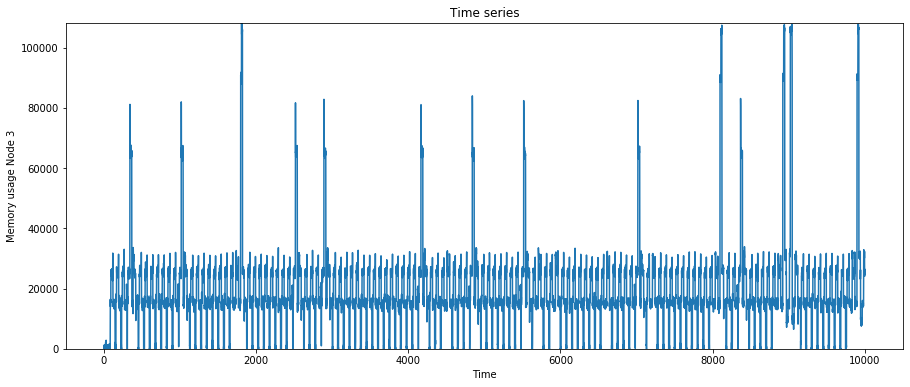

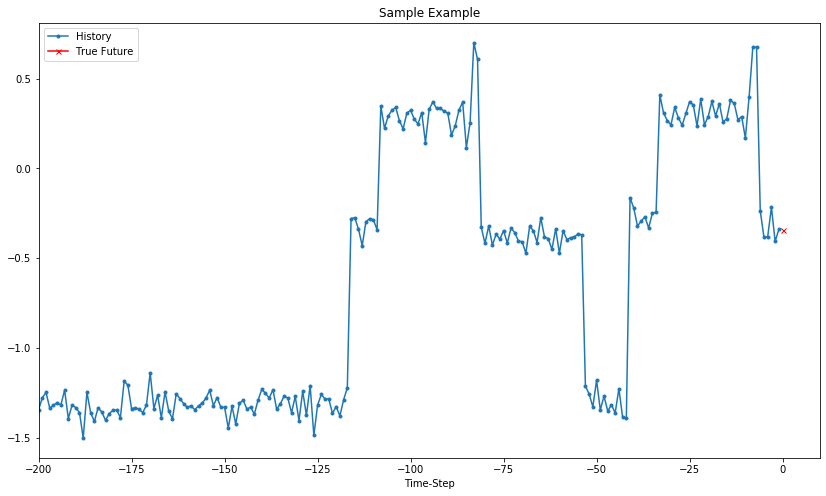

In [10]:
# Use the already saved time-series by loading them from file
ts = pd.read_pickle('ts.pkl')

# Plot time-series
# plot_ts(ts["memory"], node)

# Plot time-series
plot_ts(ts["memory"][:10000], node)

# Set seed for reproducibility
tf.random.set_seed(13)

# Take data
ts_data = ts['memory']
ts_data.index = ts['time']

# We will use 70% percent of data to train
TRAIN_SPLIT = 0.7
TRAIN_SPLIT = int(TRAIN_SPLIT*ts_data.size)

# Normalize data
ts_data_mean = ts_data[:TRAIN_SPLIT].mean()
ts_data_std = ts_data[:TRAIN_SPLIT].std()
ts_data = (ts_data-ts_data_mean) / ts_data_std

# Get the training and validation data and targets
univariate_past_history = 200
univariate_future_target = 1

x_train, y_train = univariate_data(ts_data, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)
x_val, y_val = univariate_data(ts_data, TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target)

show_plot([x_train[0], y_train[0]], univariate_future_target, 'Sample Example')

### Model

In [20]:
BATCH_SIZE = 100
# BUFFER_SIZE = 10000

train_univariate = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_univariate = train_univariate.cache().batch(BATCH_SIZE).repeat()

print(train_univariate)

val_univariate = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

print(val_univariate)

lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(128, input_shape=x_train.shape[-2:]),
    tf.keras.layers.Dense(univariate_future_target)
])

lstm_model.compile(optimizer='adam', loss='mae')

EVALUATION_INTERVAL = 200
EPOCHS = 10

lstm_model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate, validation_steps=50)

<RepeatDataset shapes: ((None, 150, 1), (None, 1, 1)), types: (tf.float64, tf.float64)>
<RepeatDataset shapes: ((None, 150, 1), (None, 1, 1)), types: (tf.float64, tf.float64)>
Train for 200 steps, validate for 50 steps
Epoch 1/10
200/200 [==============================] - 6s 30ms/step - loss: 0.2614 - val_loss: 0.1870
Epoch 2/10
200/200 [==============================] - 4s 22ms/step - loss: 0.1701 - val_loss: 0.1631
Epoch 3/10
200/200 [==============================] - 4s 22ms/step - loss: 0.1620 - val_loss: 0.1659 ETA: 0s - los
Epoch 4/10
200/200 [==============================] - 4s 22ms/step - loss: 0.1604 - val_loss: 0.1626
Epoch 5/10
200/200 [==============================] - 4s 22ms/step - loss: 0.1623 - val_loss: 0.1554
Epoch 6/10
200/200 [==============================] - 4s 22ms/step - loss: 0.1482 - val_loss: 0.1504
Epoch 7/10
200/200 [==============================] - 4s 22ms/step - loss: 0.1544 - val_loss: 0.1537ETA: 0s - loss: 0.15
Epoch 8/10
200/200 [====================

### Plot results

In [ ]:
for x, y in val_univariate:
    plot = []
    for i in range(len(x)):
        plot.append(show_plot([x[i].numpy(), y[i].numpy(),
                        lstm_model.predict(x)[i]], univariate_future_target, 'Simple LSTM model'))
    

### Predict for val set and plot

In [22]:
y_pred = lstm_model.predict(x_val)

y_val_plot = ms_val(y_val)
y_pred = avg_pred(y_pred)

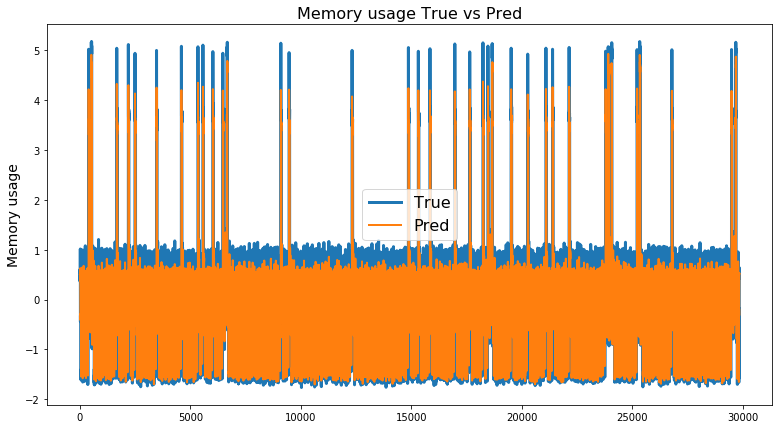

In [23]:
line_plot(y_val_plot.flatten(), y_pred.flatten(), 'True', 'Pred')

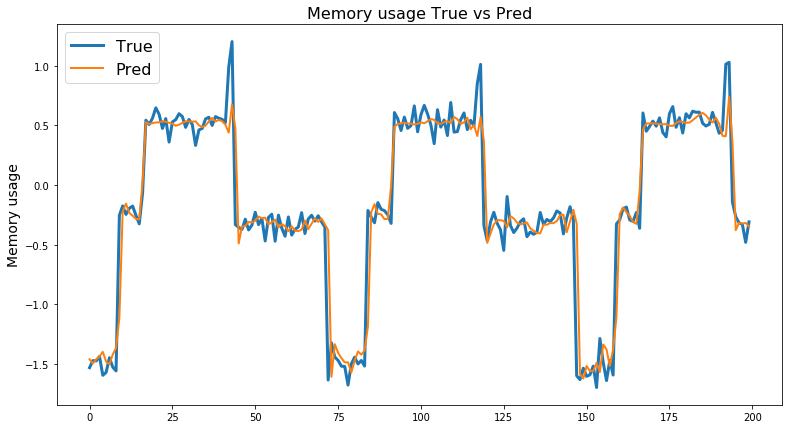

In [24]:
line_plot(y_val_plot.flatten()[800:1000], y_pred.flatten()[800:1000], 'True', 'Pred')

## 5 steps forecasting

### Plot and preprocess data

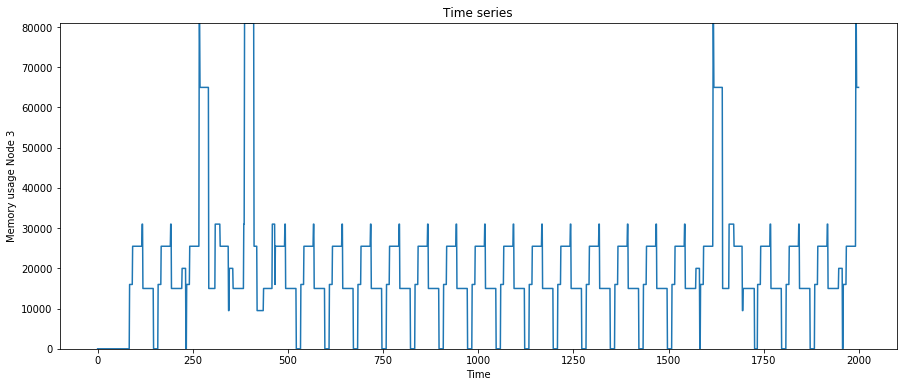

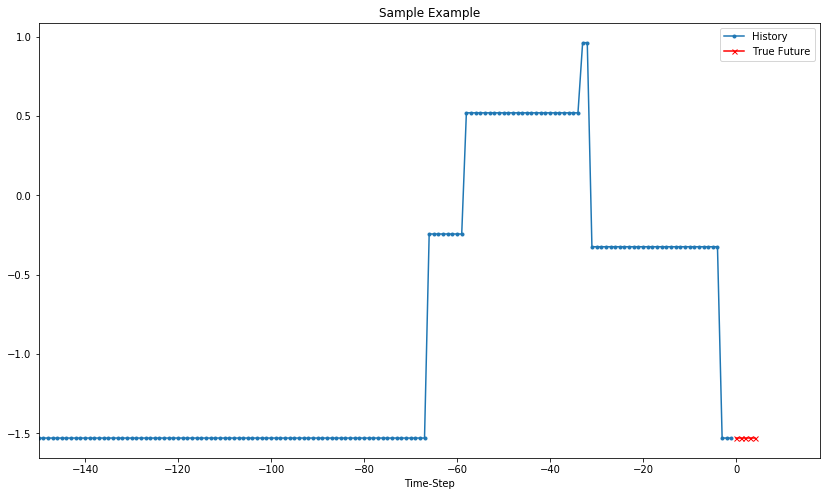

In [12]:
# Use the already saved time-series by loading them from file
ts = pd.read_pickle('ts.pkl')

# Plot time-series
# plot_ts(ts["memory"], node)

# Plot time-series
plot_ts(ts["memory"][:2000], node)

# Set seed for reproducibility
tf.random.set_seed(13)

# Take data
ts_data = ts['memory']
ts_data.index = ts['time']

# We will use 70% percent of data to train
TRAIN_SPLIT = 0.7
TRAIN_SPLIT = int(TRAIN_SPLIT*ts_data.size)

# Normalize data
ts_data_mean = ts_data[:TRAIN_SPLIT].mean()
ts_data_std = ts_data[:TRAIN_SPLIT].std()
ts_data = (ts_data-ts_data_mean) / ts_data_std

# Get the training and validation data and targets
univariate_past_history = 150
univariate_future_target = 5

x_train, y_train = univariate_data(ts_data, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)
x_val, y_val = univariate_data(ts_data, TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target)

show_plot([x_train[0], y_train[0]], univariate_future_target, 'Sample Example')

### Model

In [13]:
BATCH_SIZE = 100
# BUFFER_SIZE = 10000

train_univariate = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_univariate = train_univariate.cache().batch(BATCH_SIZE).repeat()

print(train_univariate)

val_univariate = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

print(train_univariate)

lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(128, input_shape=x_train.shape[-2:]),
    tf.keras.layers.Dense(univariate_future_target)
])

lstm_model.compile(optimizer='adam', loss='mae')

EVALUATION_INTERVAL = 200
EPOCHS = 10

lstm_model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate, validation_steps=50)

<RepeatDataset shapes: ((None, 150, 1), (None, 5, 1)), types: (tf.float64, tf.float64)>
<RepeatDataset shapes: ((None, 150, 1), (None, 5, 1)), types: (tf.float64, tf.float64)>
Train for 200 steps, validate for 50 steps
Epoch 1/10
  1/200 [..............................] - ETA: 3:59

UnknownError:  [_Derived_]  Fail to find the dnn implementation.
	 [[{{node CudnnRNN}}]]
	 [[sequential_2/lstm_2/StatefulPartitionedCall]] [Op:__inference_distributed_function_8400]

Function call stack:
distributed_function -> distributed_function -> distributed_function


### Plot results

In [ ]:
for x, y in val_univariate:
    plot = []
    for i in range(len(x)):
        plot.append(show_plot([x[i].numpy(), y[i].numpy(),
                        lstm_model.predict(x)[i]], univariate_future_target, 'Simple LSTM model'))
    

### Predict for val set and plot

In [15]:
y_pred = lstm_model.predict(x_val)

y_val_plot = ms_val(y_val)
y_pred = avg_pred(y_pred)

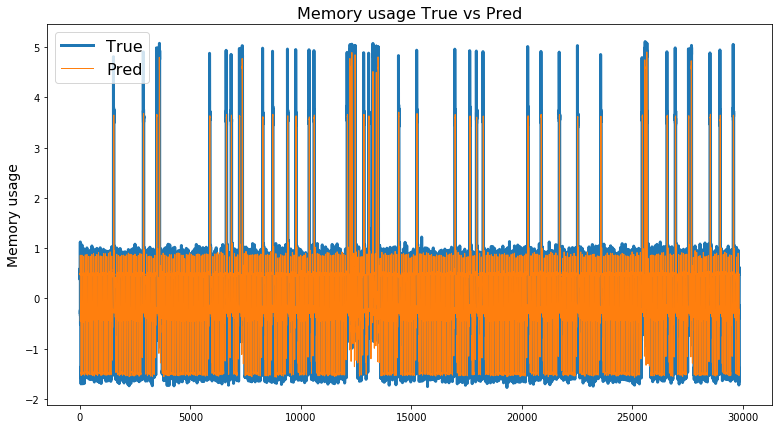

In [16]:
line_plot(y_val_plot.flatten(), y_pred.flatten(), 'True', 'Pred')

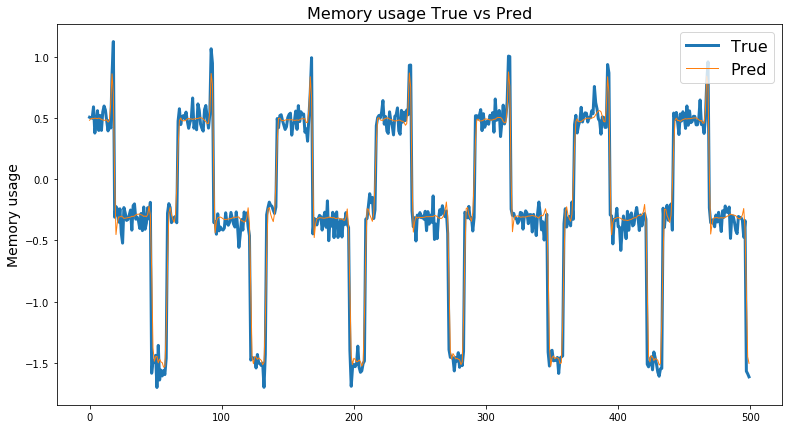

In [17]:
line_plot(y_val_plot.flatten()[:500], y_pred.flatten()[:500], 'True', 'Pred')

## X steps forecasting

### Plot and preprocess data

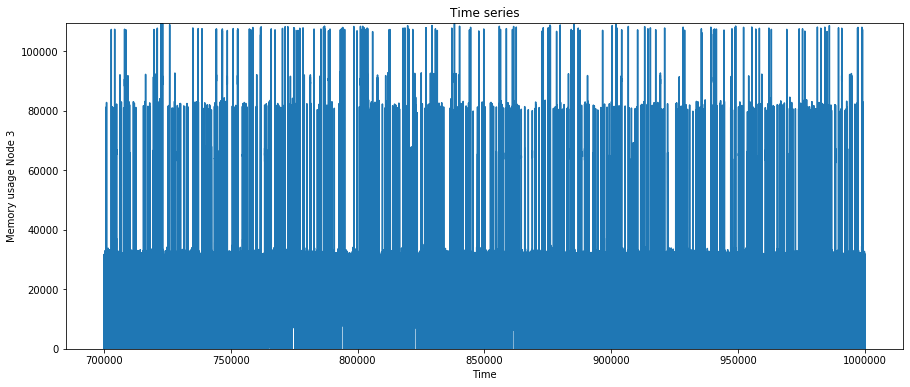

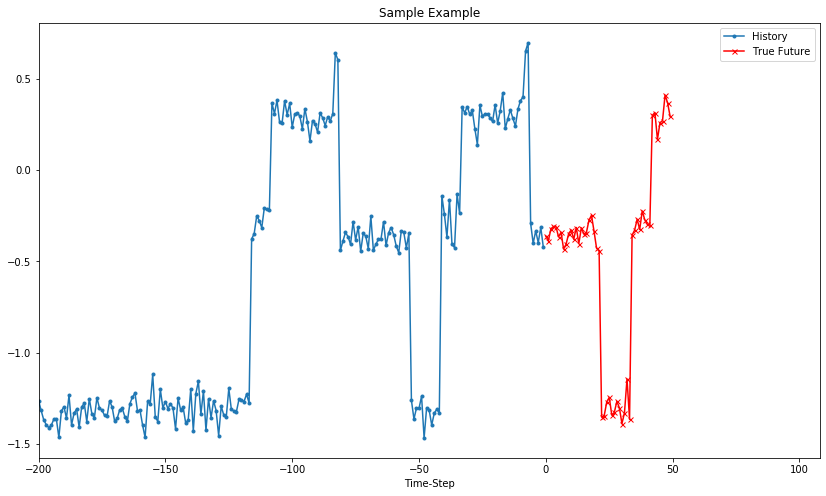

In [3]:
# Use the already saved time-series by loading them from file
ts = pd.read_pickle('ts.pkl')

# Plot time-series
# plot_ts(ts["memory"], node)

# Plot time-series
plot_ts(ts["memory"][700000:], node)

# Set seed for reproducibility
tf.random.set_seed(13)

# Take data
ts_data = ts['memory']
ts_data.index = ts['time']

# We will use 70% percent of data to train
TRAIN_SPLIT = 0.695
TRAIN_SPLIT = int(TRAIN_SPLIT*ts_data.size)

# Normalize data
ts_data_mean = ts_data[:TRAIN_SPLIT].mean()
ts_data_std = ts_data[:TRAIN_SPLIT].std()
ts_data = (ts_data-ts_data_mean) / ts_data_std

# Get the training and validation data and targets
univariate_past_history = 200
univariate_future_target = 50

x_train, y_train = univariate_data(ts_data, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)
x_val, y_val = univariate_data(ts_data, TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target)

show_plot([x_train[0], y_train[0]], univariate_future_target, 'Sample Example')

### Model

In [5]:
BATCH_SIZE = 100
# BUFFER_SIZE = 10000

train_univariate = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_univariate = train_univariate.cache().batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(128, input_shape=x_train.shape[-2:]),
    tf.keras.layers.Dense(univariate_future_target)
])

lstm_model.compile(optimizer='adam', loss='mae')

EVALUATION_INTERVAL = 200
EPOCHS = 9

lstm_model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate, validation_steps=50)

Train for 200 steps, validate for 50 steps
Epoch 1/9
200/200 [==============================] - 8s 40ms/step - loss: 0.4643 - val_loss: 0.3653
Epoch 2/9
200/200 [==============================] - 6s 29ms/step - loss: 0.3499 - val_loss: 0.3069
Epoch 3/9
200/200 [==============================] - 6s 29ms/step - loss: 0.3673 - val_loss: 0.28823
Epoch 4/9
200/200 [==============================] - 6s 29ms/step - loss: 0.3448 - val_loss: 0.2703
Epoch 5/9
200/200 [==============================] - 6s 29ms/step - loss: 0.4081 - val_loss: 0.2618
Epoch 6/9
200/200 [==============================] - 6s 29ms/step - loss: 0.3258 - val_loss: 0.2511
Epoch 7/9
200/200 [==============================] - 6s 28ms/step - loss: 0.2849 - val_loss: 0.2598
Epoch 8/9
200/200 [==============================] - 6s 29ms/step - loss: 0.3834 - val_loss: 0.2544
Epoch 9/9
200/200 [==============================] - 6s 29ms/step - loss: 0.3296 - val_loss: 0.2473


### Plot results

In [ ]:
for x, y in val_univariate:
    plot = []
    for i in range(len(x)):
        plot.append(show_plot([x[i].numpy(), y[i].numpy(),
                        lstm_model.predict(x)[i]], univariate_future_target, 'Memory usage True vs pred'))
    

### Predict for val set and plot

In [6]:
y_pred = lstm_model.predict(x_val)

y_val_plot = ms_val(y_val)
y_pred = avg_pred(y_pred)

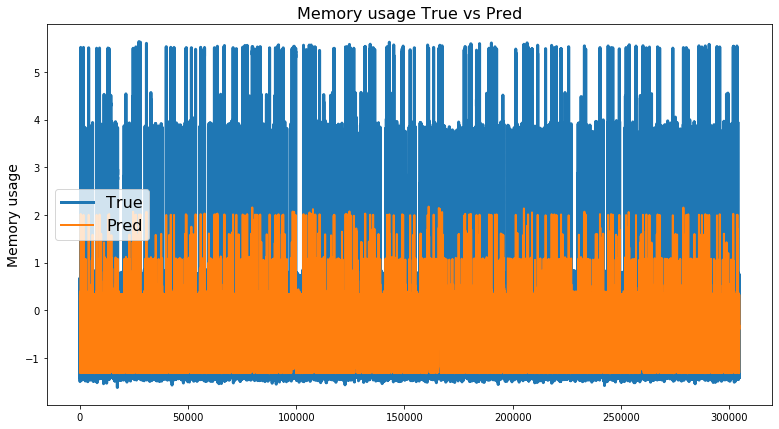

In [7]:
line_plot(y_val_plot.flatten(), y_pred.flatten(), 'True', 'Pred')

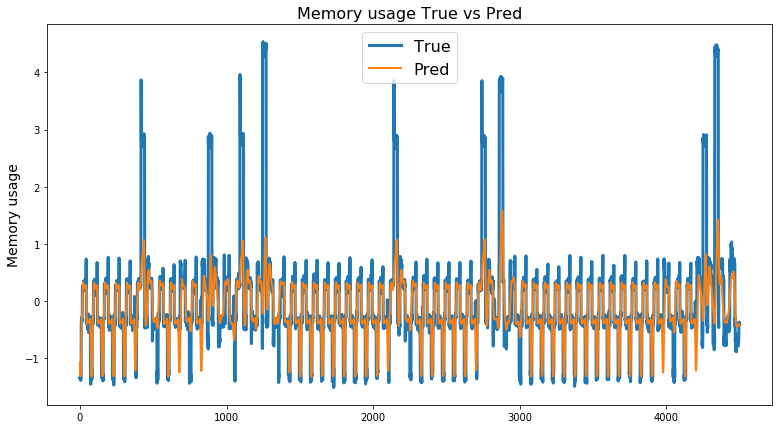

In [10]:
line_plot(y_val_plot.flatten()[20000:24500], y_pred.flatten()[20000:24500], 'True', 'Pred')

In [17]:
y_pred.shape

(304750,)

In [18]:
y_val_plot = y_val_plot[0:304750].flatten()

In [19]:
y_val_plot.shape

(304750,)

In [20]:
arr = np.array((y_val_plot, y_pred))
arr = arr.T

In [21]:
df = pd.DataFrame(data=arr, columns=["y_true", "y_pred"])

In [22]:
len(df)

304750

In [23]:
df.to_csv('dataset_2.csv')